# KB-CAPTCHA Documentation

## Overview
This notebook is meant to serve as documentation for the rationale and processes for the design of this project with regard to its data analysis.
For instructions on running the solution, installation and clean-up, please see the README at the root of the project files.

## Hypothesis
The hypothesis for our solution is that users can successfully be distinguished from a large class of bots based on the typing metrics of key held time, keystroke delay time, key overlap percentage and standard deviation of the first two values using unsupervised machine learning techniques.

## Data Set Description
We will source the data for this project from the "136M Keystrokes" data set available [here](https://userinterfaces.aalto.fi/136Mkeystrokes/). This data set contains the following fields:

* Participant id (Integer)
* Test section id (Integer)
* Sentence (String)
* User input (String)
* Keystroke id (Integer)
* Press time (Integer)
* Release time (Integer)
* Letter (String)
* Keycode (Integer)

To test our hypothesis, we need to extract and convert the data from these fields. 

* Average key held time
* Standard deviation of key held time
    * We can derive both of these fields by subtracting the "Press time" from the "Release time" of each entry and then taking the average / standard deviation of the results.
* Average time between keystrokes
* Standard deviation of time between strokes
    * Both of these fields can be derived by subtracting the "Press time" of the current key from the "Press time" of the previous key and taking the average / standard deviation of the results.
* Percentage of keys pressed while the previous key is still held down
    * We can determine if a given key is an "overlap" key by checking if its "Press time" is before the previous key's "Release time". Then, add up overlap keys and divide by the total.

## Data Set Exploration

To explore the viability of standard deviation as a measure of spread as well as identify outliers, we will visualize a random sample of the data and try to make observations and generalizations.

First, let's visualize the distributions for key held time.

### Key Held Time



Generating sample charts. This can take a while.
Selecting file ../Data/raw/1887_keystrokes.txt
Selecting file ../Data/raw/1580_keystrokes.txt
Selecting file ../Data/raw/2046_keystrokes.txt
Selecting file ../Data/raw/2082_keystrokes.txt


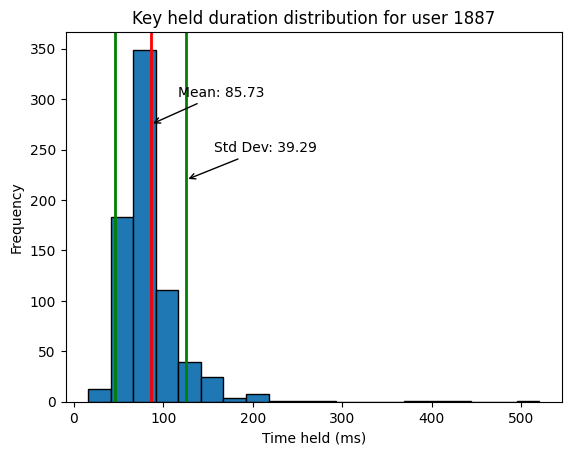

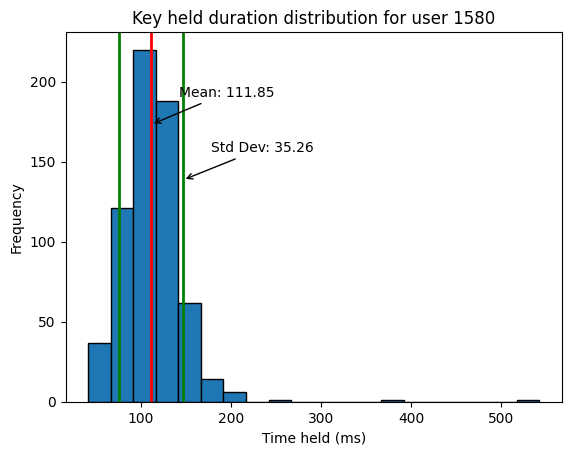

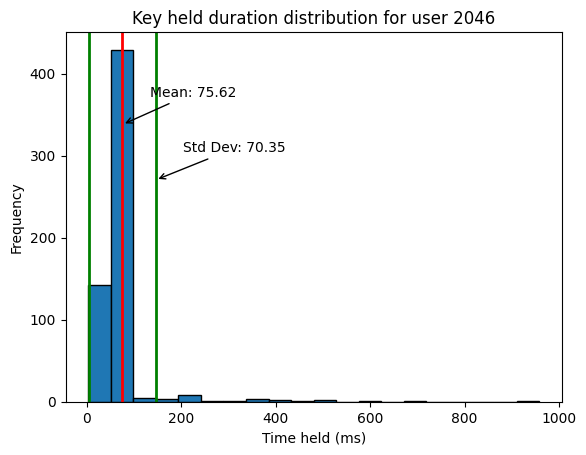

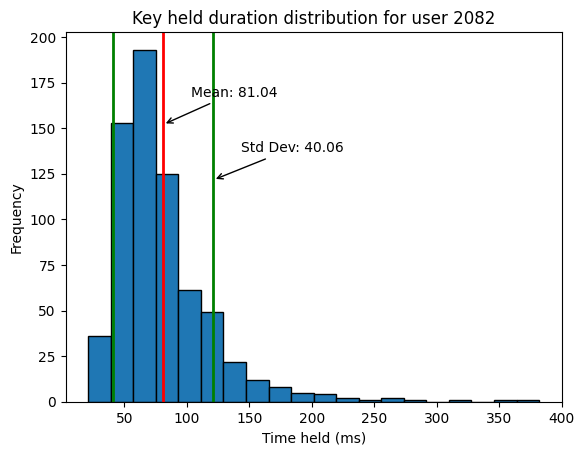

Finished


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import re
%matplotlib inline 

print("Generating sample charts. This can take a while.")

#The product of these two should equal the 
graph_row_count = 2
graph_col_count = 2
number_of_samples = graph_row_count * graph_col_count


directory = "../Data/raw/"
all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

files_to_show = []
for i in range():
    file_to_add = os.path.join(directory, random.choice(all_files))
    print(f"Selecting file {file_to_add}")
    files_to_show.append(file_to_add)

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["TIME_HELD"] = data_frame["RELEASE_TIME"] - data_frame["PRESS_TIME"]
    
    time_held_std_dev = data_frame["TIME_HELD"].std()
    time_held_mean = data_frame["TIME_HELD"].mean()

    plt.hist(data_frame['TIME_HELD'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    plt.title(f'Key held duration distribution for user {user_id}')
    plt.xlabel('Time held (ms)')
    plt.ylabel('Frequency')

    plt.axvline(time_held_mean, color='red', linestyle='solid', linewidth=2)
    plt.annotate(f'Mean: {time_held_mean:.2f}', xy=(time_held_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    plt.axvline(time_held_mean + time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    plt.axvline(time_held_mean - time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    plt.annotate(f'Std Dev: {time_held_std_dev:.2f}', xy=(time_held_mean + time_held_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))


    plt.show()

print("Finished")


Let's remove outliers. To do this, we will remove data points where the key is held for more than 500 milliseconds.

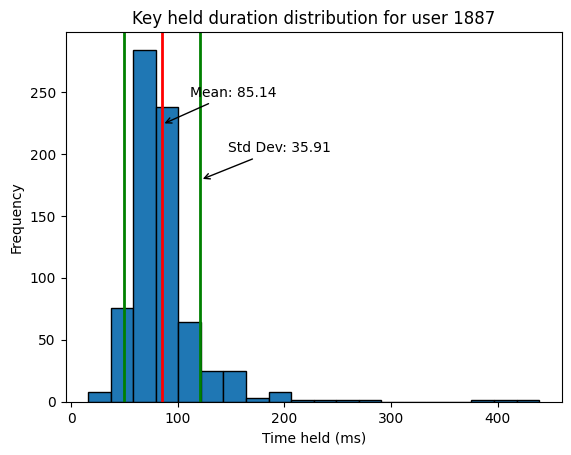

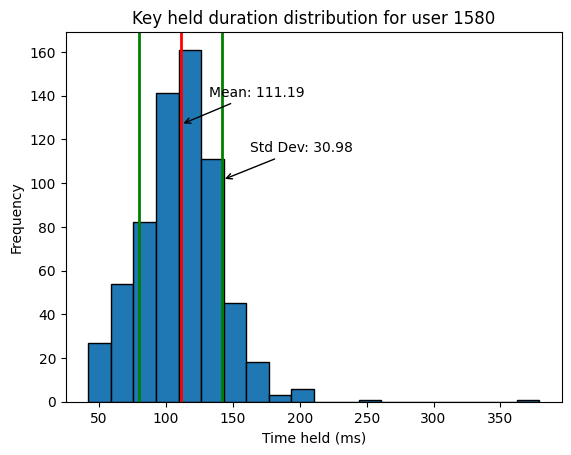

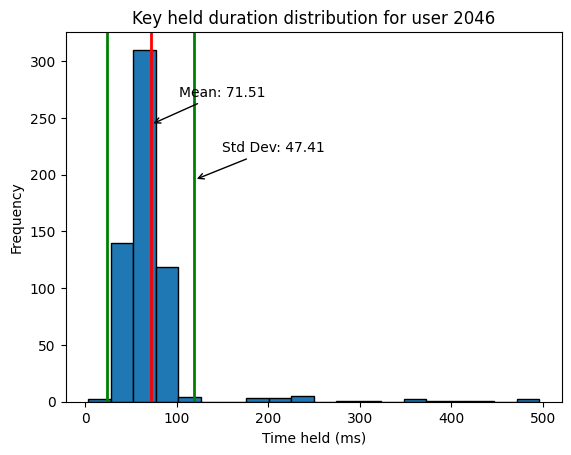

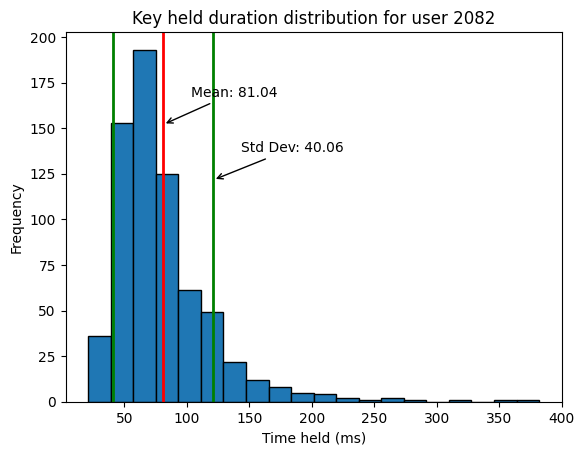

In [83]:
for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["TIME_HELD"] = data_frame["RELEASE_TIME"] - data_frame["PRESS_TIME"]
    data_frame = data_frame.query("TIME_HELD <= 500")
    time_held_std_dev = data_frame["TIME_HELD"].std()
    time_held_mean = data_frame["TIME_HELD"].mean()

    plt.hist(data_frame['TIME_HELD'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    plt.title(f'Key held duration distribution for user {user_id}')
    plt.xlabel('Time held (ms)')
    plt.ylabel('Frequency')

    plt.axvline(time_held_mean, color='red', linestyle='solid', linewidth=2)
    plt.annotate(f'Mean: {time_held_mean:.2f}', xy=(time_held_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    plt.axvline(time_held_mean + time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    plt.axvline(time_held_mean - time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    plt.annotate(f'Std Dev: {time_held_std_dev:.2f}', xy=(time_held_mean + time_held_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.show()

This seems to produce much better results. We don't want to exclude much more than this however, as a very slow typist may have data that is shifted to the right toward the 500 millisecond cutoff.

Now, lets observe how the distributions for time between strokes looks.

### Time Between Strokes

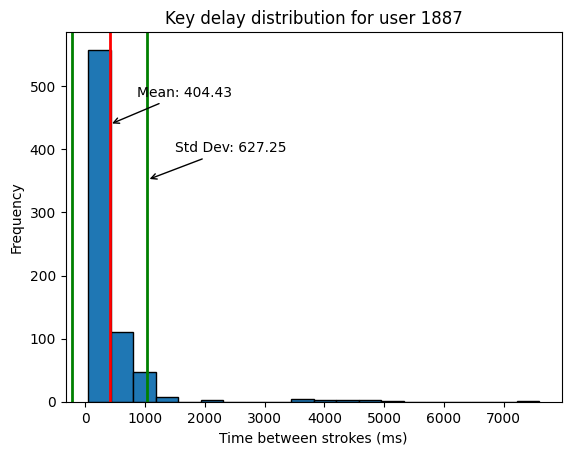

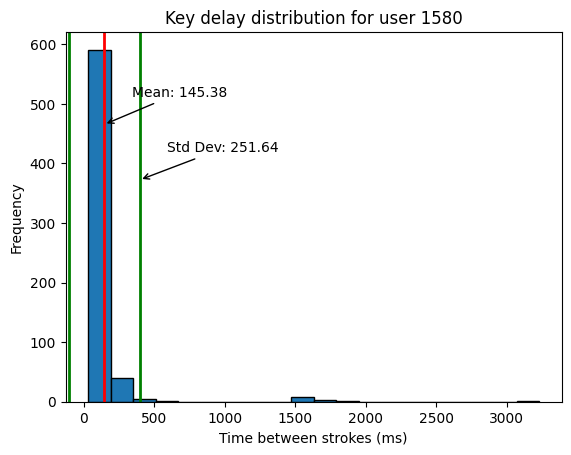

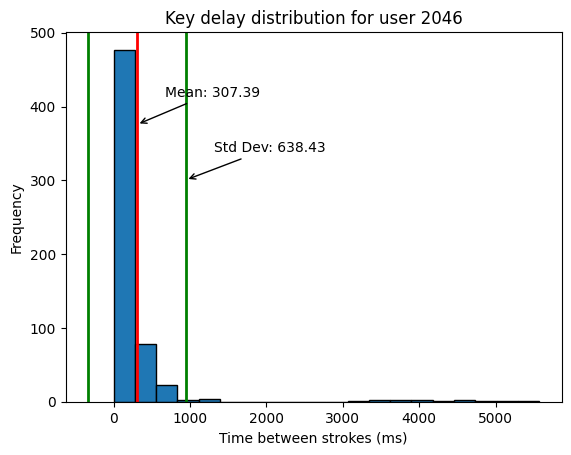

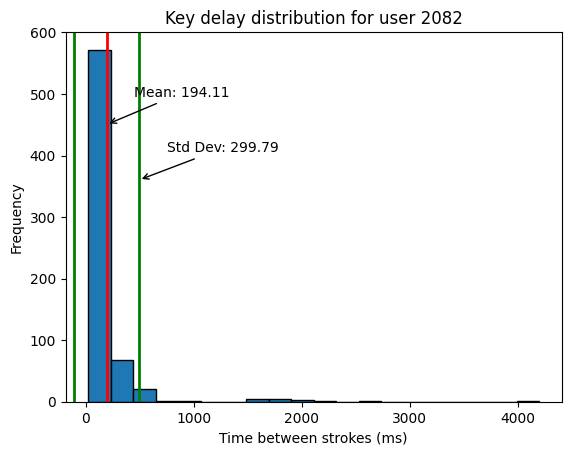

In [84]:
figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(10, 8))

graph_row = 0
graph_col = 0

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["KEY_DELAY"] = data_frame["PRESS_TIME"].shift(-1) - data_frame["PRESS_TIME"]
    
    key_delay_std_dev = data_frame["KEY_DELAY"].std()
    key_delay_mean = data_frame["KEY_DELAY"].mean()
    
    plt.hist(data_frame['KEY_DELAY'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    plt.title(f'Key delay distribution for user {user_id}')
    plt.xlabel('Time between strokes (ms)')
    plt.ylabel('Frequency')

    plt.axvline(key_delay_mean, color='red', linestyle='solid', linewidth=2)
    plt.annotate(f'Mean: {key_delay_mean:.2f}', xy=(key_delay_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    plt.axvline(key_delay_mean + key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    plt.axvline(key_delay_mean - key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    plt.annotate(f'Std Dev: {key_delay_std_dev:.2f}', xy=(key_delay_mean + key_delay_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.show()

These are unfortunately not very informative due to the extreme outliers. Let's do the same visualization, but remove all entries with more than 1 second of loiter time.


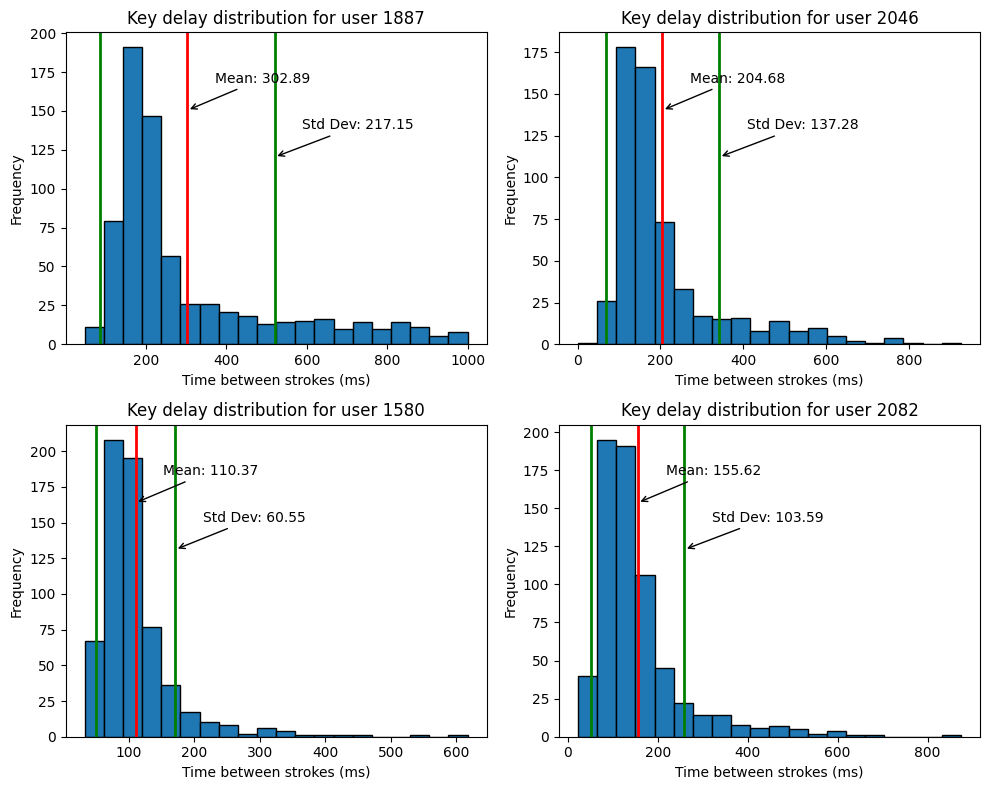

In [89]:
figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(10, 8))

graph_row = 0
graph_col = 0

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["KEY_DELAY"] = data_frame["PRESS_TIME"].shift(-1) - data_frame["PRESS_TIME"]
    data_frame = data_frame.query("KEY_DELAY <= 1000")
    data_frame = data_frame.query("KEY_DELAY > 0")
    
    key_delay_std_dev = data_frame["KEY_DELAY"].std()
    key_delay_mean = data_frame["KEY_DELAY"].mean()
    
    subplot[graph_row][graph_col].hist(data_frame['KEY_DELAY'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    subplot[graph_row][graph_col].set_title(f'Key delay distribution for user {user_id}')
    subplot[graph_row][graph_col].set_xlabel('Time between strokes (ms)')
    subplot[graph_row][graph_col].set_ylabel('Frequency')

    subplot[graph_row][graph_col].axvline(key_delay_mean, color='red', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Mean: {key_delay_mean:.2f}', xy=(key_delay_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    subplot[graph_row][graph_col].axvline(key_delay_mean + key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].axvline(key_delay_mean - key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Std Dev: {key_delay_std_dev:.2f}', xy=(key_delay_mean + key_delay_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    
    graph_row += 1

    if graph_row >= graph_row_count:
        graph_col += 1
        graph_row %= graph_row_count
    
plt.tight_layout()
plt.show()


We can see that the data is roughly normal shaped, though does have a non-negligible positive skew. To get a more representative description of the data, let's try using the interquartile range (IQR) instead.

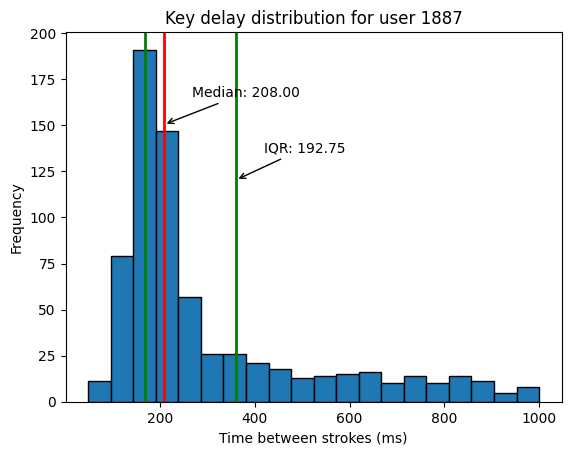

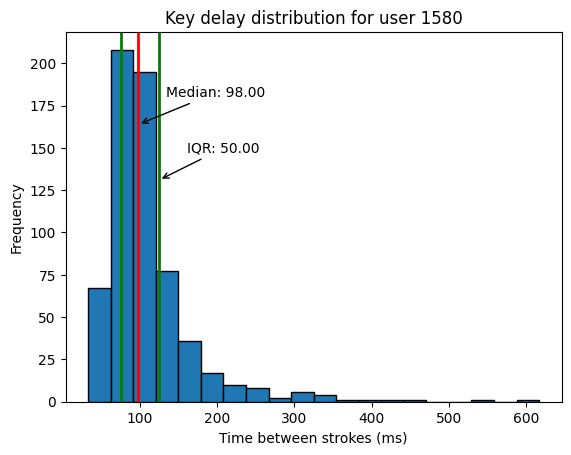

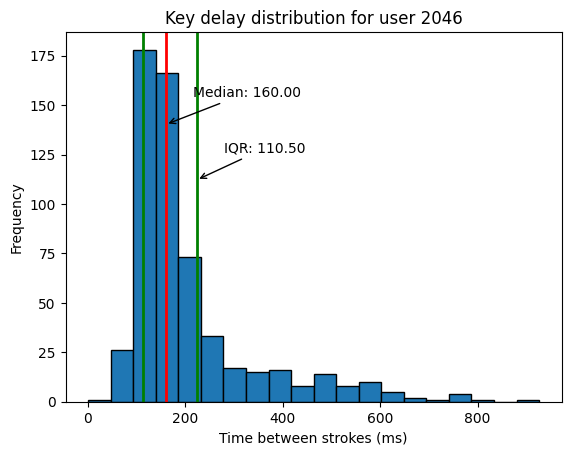

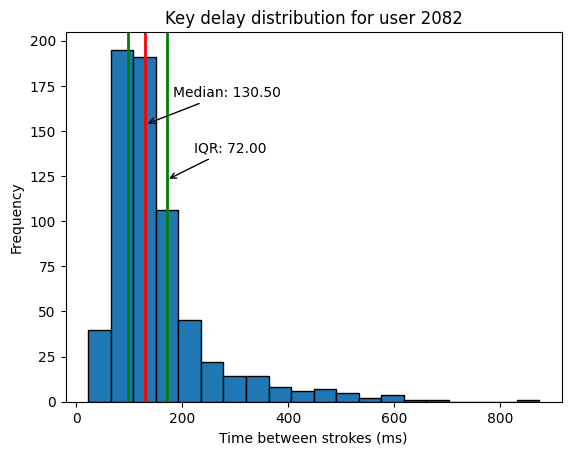

In [90]:
for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["KEY_DELAY"] = data_frame["PRESS_TIME"].shift(-1) - data_frame["PRESS_TIME"]
    data_frame = data_frame.query("KEY_DELAY <= 1000")
    data_frame = data_frame.query("KEY_DELAY > 0")

    first_quartile = data_frame["KEY_DELAY"].quantile(0.25)
    third_quartile = data_frame["KEY_DELAY"].quantile(0.75)
    key_delay_median = data_frame["KEY_DELAY"].median()

    
    plt.hist(data_frame['KEY_DELAY'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    plt.title(f'Key delay distribution for user {user_id}')
    plt.xlabel('Time between strokes (ms)')
    plt.ylabel('Frequency')

    plt.axvline(key_delay_median, color='red', linestyle='solid', linewidth=2)
    plt.annotate(f'Median: {key_delay_median:.2f}', xy=(key_delay_median, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    plt.axvline(first_quartile, color='green', linestyle='solid', linewidth=2)
    plt.axvline(third_quartile, color='green', linestyle='solid', linewidth=2)
    plt.annotate(f'IQR: {third_quartile - first_quartile:.2f}', xy=(third_quartile, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    plt.show()

## Data Cleaning and Preparation

As we can see above, the data is roughly normal in shape. This makes the standard deviation a good measure of spread. Further, we can see there is consistently outliers to the right. Many of the samples have averages around 200ms

## Hypothesis Acceptance Evaluation
